# Reinforce  Monte Carlo Algorithm
In this notebook, you'll code The Reinforce (also called Monte Carlo Policy Gradient) algorithm  from scratch: .

Reinforce is a *Policy-based method*: a Deep Reinforcement Learning algorithm that tries **to optimize the policy directly without using an action-value function**.

More precisely, Reinforce is a *Policy-gradient method*, a subclass of *Policy-based methods* that aims **to optimize the policy directly by estimating the weights of the optimal policy using gradient ascent**.

To test its robustness, we're going to train it in Cartpole-v1 environment

## Import the packages

In [1]:
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Gym
import gym


## Check if we have a GPU
- Let's check if we have a GPU `device:cuda0`

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Agent: Playing CartPole-v1 🤖
### The CartPole-v1 environment

> A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

So, we start with CartPole-v1. The goal is to push the cart left or right **so that the pole stays in the equilibrium.**

The episode ends if:
- The pole Angle is greater than ±12°
- Cart Position is greater than ±2.4
- Episode length is greater than 500

We get a reward 💰 of +1 every timestep the Pole stays in the equilibrium.

In [3]:
env_id = "CartPole-v1"
# Create the env
env = gym.make(env_id)

# Create the evaluation env
eval_env = gym.make(env_id)

# Get the state space and action space
s_size = env.observation_space.shape[0]
a_size = env.action_space.n

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [4]:
print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

The State Space is:  4
Sample observation [ 3.6433706e+00  2.6270582e+38 -8.4108710e-02  2.1622545e+38]


In [5]:
print("\n _____ACTION SPACE_____ \n")
print("The Action Space is: ", a_size)
print("Action Space Sample", env.action_space.sample()) # Take a random action


 _____ACTION SPACE_____ 

The Action Space is:  2
Action Space Sample 1


## Let's build the Reinforce Architecture
<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit6/reinforce.png" alt="Reinforce"/>

So we want:
- Two fully connected layers (fc1 and fc2).
- Using ReLU as activation function of fc1
- Using Softmax to output a probability distribution over actions

In [6]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim = 1)
        return x

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


- Since **we want to sample an action from the probability distribution over actions (i.e., Stochastic policy)**, we can't use `action = np.argmax(m)` since it will always output the action that have the highest probability.

- We need to replace with `action = m.sample()` that will sample an action from the probability distribution P(.|s)

### Let's build the Reinforce Training Algorithm
This is the Reinforce algorithm pseudocode:
<img src="https://github.com/malkiAbdelhamid/Advanced-Deep-Learning-2023-2024-esisba/blob/master/lab3_Policy_Gradient/Reinforce_algo.png?raw=true" alt="Policy gradient pseudocode"/>

# Building the parts of our algorithm #
The main steps for building a Reinforce Algo are:
1. Generates a trajectory (Line 3)
2. Compute the discounted returns (Lines 4 & 5)
3. Standardization of the returns
4. Calculate current loss (objective function $J(\theta)$) and estimate the gradient (Lines 6 & 7)
5. Update parameters (Line 8)



### Line 3 of pseudocode
Based on the policy, the method **generate_trajectory(policy, max_t)** generates a trajectory and return two lists:
  - saved_log_probs: the log probability of each action in the trajectory
  - rewards: the list of the obtained rewards

In [15]:
 def generate_trajectory(policy, max_t):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            # add the obtained probability to saved_log_probs list
            saved_log_probs.append(log_prob)
            # apply the action on the env
            state, reward, done, _ = env.step(action)
            # add the obtained rewards to rewards list
            rewards.append(reward)
            # if done, reset the env
            if done:
                break


        return  saved_log_probs, rewards

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


 ### Lines 4 & 5 of pseudocode
 the method **computer_cumulative_reward(rewards,max_t,gamma)** Compute the discounted returns at each timestep, as the sum of the gamma-discounted return at time t (G_t) + the reward at time t

In [16]:
# Line 6 of pseudocode: calculate the return

def computer_cumulative_reward(rewards,max_t,gamma):
        ##we calculate the returns at timestep t as:
        #           G_(t)= reward[t] + gamma * G_(t+1)
        #
        ## We compute this starting from the last timestep to the first, in order
        ## to employ the formula presented above and avoid redundant computations that would be needed
        ## if we were to do it from first to last.

        ## Hence, the queue "returns" will hold the returns in chronological order, from t=0 to t=n_steps
        ## thanks to the appendleft() function which allows to append to the position 0 in constant time O(1)
        ## a normal python list would instead require O(N) to do this.
        returns = deque(maxlen=max_t)
        n_steps = len(rewards)
        for t in range(n_steps)[::-1]:
            disc_return_t = (returns[0] if len(returns)>0 else 0)
            returns.appendleft(rewards[t] + gamma * disc_return_t)
        return returns

### standardization of the returns
- is employed to make training more stable


In [17]:
def returns_standardization(returns):
        eps = np.finfo(np.float32).eps.item()
        ## eps is the smallest representable float, which is
        # added to the standard deviation of the returns to avoid numerical instabilities
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        return returns

 ### Line 6, 7 & 8 of pseudocode
**why do we minimize the loss**? You talked about Gradient Ascent not Gradient Descent?

- We want to maximize our utility function $J(\theta)$ but in PyTorch like in Tensorflow it's better to **minimize an objective function.**
    - So let's say we want to reinforce action 3 at a certain timestep. Before training this action P is 0.25.
    - So we want to modify $\theta$ such that $\pi_\theta(a_3|s; \theta) > 0.25$
    - Because all P must sum to 1, max $\pi_\theta(a_3|s; \theta)$ will **minimize other action probability.**
    - So we should tell PyTorch **to min $1 - \pi_\theta(a_3|s; \theta)$.**
    - This loss function approaches 0 as $\pi_\theta(a_3|s; \theta)$ nears 1.
    - So we are encouraging the gradient to max $\pi_\theta(a_3|s; \theta)$

In [18]:

def compute_loss_and_train_policy(optimizer, saved_log_probs, returns):
        # Line 6
        policy_loss = []
        for log_prob, disc_return in zip(saved_log_probs, returns):
            #------add code here--------#
            policy_loss.append(-log_prob * disc_return)
        policy_loss = torch.cat(policy_loss).sum()

        # Line 7 & 8: PyTorch prefers gradient descent
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()


## Merge all functions into the reinforce method ##

You will now see how the overall **Reinforce Algo** is structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.

In [19]:
def reinforce(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
    # Help us to calculate the score during the training
    scores_deque = deque(maxlen=100)
    scores = []

    for i_episode in range(1, n_training_episodes+1):

        # Line 3 of pseudocode
        saved_log_probs, rewards= generate_trajectory(policy, max_t)
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Lines 4 & 5 of pseudocode: calculate the return
        returns= computer_cumulative_reward(rewards,max_t,gamma)

        ## standardization of the returns is employed to make training more stable
        returns= returns_standardization(returns)

        # Line 6, 7 & 8 of pseudocode
        compute_loss_and_train_policy(optimizer, saved_log_probs, returns)


        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

    return scores

##  Train it
- We're now ready to train our agent.
- But first, we define a variable containing all the training hyperparameters.
- You can change the training parameters (and should 😉)

In [20]:
cartpole_hyperparameters = {
    "h_size": 64,
    "n_training_episodes": 1500,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 1.0,
    "lr": 1e-2,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

In [21]:
# Create policy and place it to the device
cartpole_policy = Policy(cartpole_hyperparameters["state_space"], cartpole_hyperparameters["action_space"], cartpole_hyperparameters["h_size"]).to(device)
cartpole_optimizer = optim.Adam(cartpole_policy.parameters(), lr=cartpole_hyperparameters["lr"])

In [22]:
scores = reinforce(cartpole_policy,
                   cartpole_optimizer,
                   cartpole_hyperparameters["n_training_episodes"],
                   cartpole_hyperparameters["max_t"],
                   cartpole_hyperparameters["gamma"],
                   100)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 100	Average Score: 78.67
Episode 200	Average Score: 321.78
Episode 300	Average Score: 214.38
Episode 400	Average Score: 262.82
Episode 500	Average Score: 443.97
Episode 600	Average Score: 480.21
Episode 700	Average Score: 417.37
Episode 800	Average Score: 467.77
Episode 900	Average Score: 317.18
Episode 1000	Average Score: 500.00
Episode 1100	Average Score: 500.00
Episode 1200	Average Score: 500.00
Episode 1300	Average Score: 500.00
Episode 1400	Average Score: 491.48
Episode 1500	Average Score: 220.12


In [23]:
scores= pd.Series(scores, name="scores_REINFORCE")
scores.describe()

,scores_REINFORCE
count,1500.000000
mean,381.050000
std,168.070535
min,11.000000
25%,225.750000
50%,500.000000
75%,500.000000
max,500.000000


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


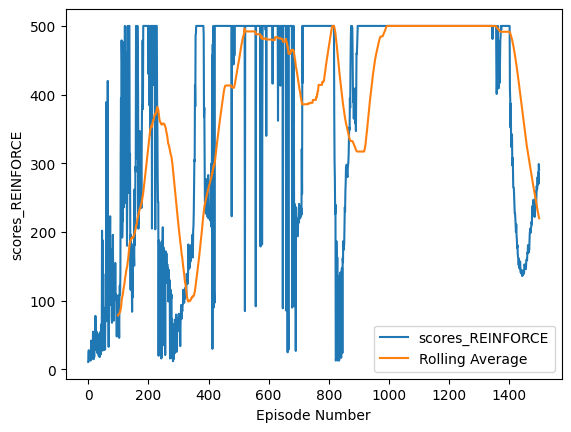

In [24]:
fig, ax = plt.subplots(1, 1)
_ = scores.plot(ax=ax, label="scores_REINFORCE")
_ = (scores.rolling(window=100)
           .mean()
           .rename("Rolling Average")
           .plot(ax=ax))
ax.legend()
_ = ax.set_xlabel("Episode Number")
_ = ax.set_ylabel("scores_REINFORCE")